# Evolutionary Strategies

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

## Overview

1. [$(1 + \lambda)$ ES](#oneplus)
2. [Approximating the gradient](#gradient)
3. [Canonical ES](#canonical)
4. [CMA-ES part 1: maximum likelihood estimation](#cmaes)
5. [CMA-ES part 2: step size adaptation](#step)

# <a name="oneplus">1.</a> The $(1 + \lambda)$ ES

The simplest Evolutionary Strategy is the $(1+1)$. In this algorithm, the best individual generated is replaced by a new individual when its **fitness** is superior to the current best.

    Initialize x randomly in ℝ
    while not terminate
        x' = x + 𝑁(0, 1)
        if f(x′) < f(x)
            x = x'
    return x

In this algorithm, at each step, we randomly sample from a Normal distribution to get one new point near the current point. However, to better inform the movement from this initial point, we could sample multiple points instead of a single one. We'll first look at examples of continuous functions, as their search space is easier to visualize.

In [1]:
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def himmelblau_v(x):
    return himmelblau(x[0], x[1])

In [2]:
def rosenbrock(x, y, a=1, B=100):
      return (a-x)**2 + B*((y-x**2))**2
    
def rosenbrock_v(x):
      return rosenbrock(x[0], x[1])

In [3]:
def warped_rastrigin(x, y):
    x = (x + 2.7) / 3
    y = (y - 4.1) / 2
    return 20 + x**2 - 10 * np.cos(2*np.pi*x) + y**2 - 10 * np.cos(2*np.pi*y)

def warped_rastrigin_v(x):
    return warped_rastrigin(x[0], x[1])

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib.colors as colors
import numpy as np
import math

In [5]:
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = himmelblau(X, Y)

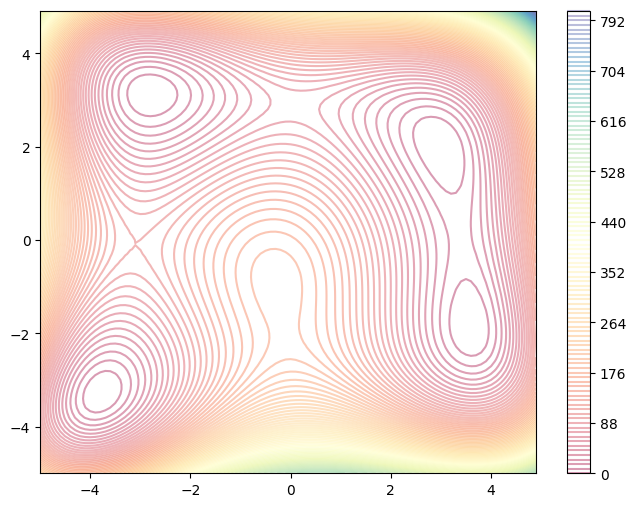

In [6]:
fig = plt.figure(figsize=(8, 6))
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral',
                 norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()), alpha=0.4)
fig.colorbar(cs)
plt.show()

We'll start with a random point $x$. We'll then use a Normal distribution to draw 20 points around $x$.

position:  [-0.1068368  -1.23300793] fitness : 180.5766535415297


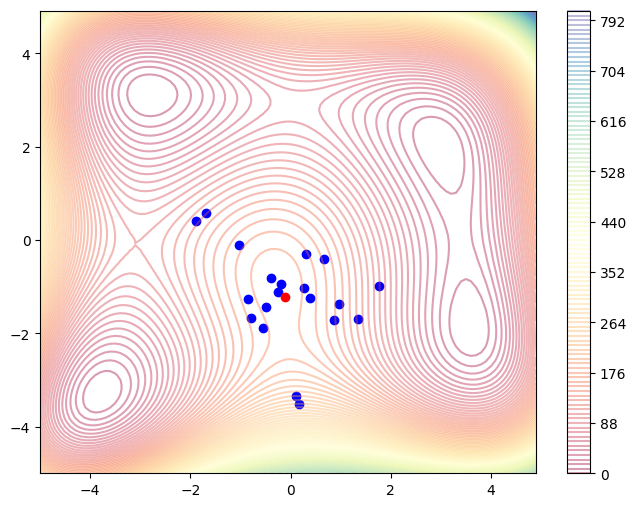

In [7]:
x = np.random.rand(2) * 4 - 2
print("position: ", x, "fitness :", himmelblau(x[0], x[1]))
x_t = np.array([x + np.random.normal(size=(2,)) for i in range(20)])
fig = plt.figure(figsize=(8, 6))
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()), alpha=0.4)
plt.scatter(x_t[:, 0], x_t[:, 1], c='b')
plt.scatter(x[0], x[1], c='r')
fig.colorbar(cs);

Having this population of points will enable us to explore the space around $x$ before moving on to the next step, which can better inform movement in the search space. However, these points might overlap or cover spaces that have already been explored. Generating too many points could slow down search, requiring more evaluations of the objective function. In many applications, that is costly.

Performing random optimization but sampling more than 1 point leads to the $(1+\lambda)$ Evolutionary Strategy. 

    Initialize x randomly in ℝ
    while not terminate
        x_p = x
        for i in [1,λ]
            x_i = x_p + 𝑁(0, 1)
            if f(x_i) < f(x)
                x = x_i
        x_p = x
    return x_p

In the scope of evolutionary algorithms, we'll refer to $x$ as a parent and all $x'$ points as offspring. Each point can also be referred to as an individual in a population, and $f(x)$ is called the fitness of the individual. Each iteration of the algorithm is called a generation.

<div class="alert alert-info">

The $(\mu/\rho,\lambda)$ or $(\mu/\rho+\lambda)$ notation signifies the configuration of parents and offspring. In this notation, $\mu$ is the number of parents, $\rho$ is the number of parents involved in creating the offspring, and $\lambda$ is the number of offspring. $(\mu/\rho+\lambda)$ means the parents can be included in the next population, whereas $(\mu/\rho,\lambda)$ means the parents are not included. $(1+\lambda)$ therefore means that 1 parent is involved in creating a population of $\lambda$ offspring and can be included in the next generation (ie, if $f(x) < f(x') \forall x'$, $x$ does not change).

</div>

In [ ]:
def oneplus_lambda(x, f, gens=200, lam=20, sig=1):
    x_best = x
    f_best = f(x)
    fits = np.zeros(gens)
    for g in range(gens):
        N = np.random.normal(size=(lam, len(x))) * sig
        for i in range(lam):
            ind = x + N[i, :]
            fi = f(ind)
            if fi < f_best:
                f_best = fi
                x_best = ind
        x = x_best
        fits[g] = f_best
    return fits, x_best

Let's run the $(1+\lambda)$ ES on the himmelblau function and record the evolution over multiple trials.

In [ ]:
f = himmelblau_v
runs = []
for i in range(5):
    x = np.random.rand(2)*10-5
    fits, _ = oneplus_lambda(x, f,lam=20)
    runs += [fits]
runs = np.array(runs)
runs_mean = np.mean(runs, 0)
runs_std = np.std(runs, 0)

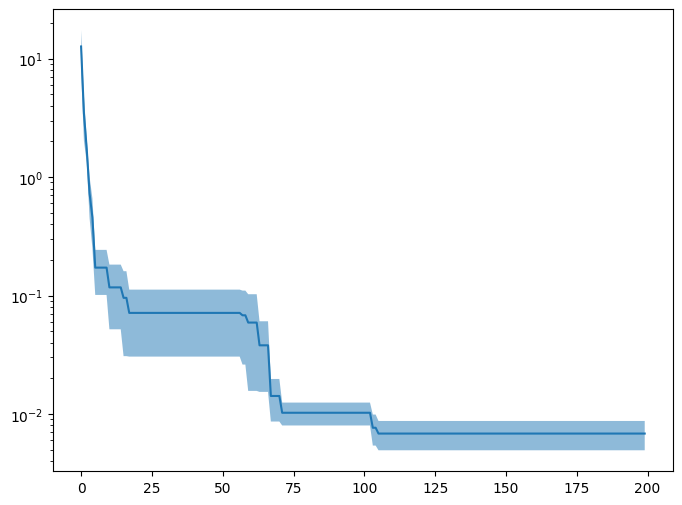

In [10]:
fig = plt.figure(figsize=(8, 6))
plt.fill_between(range(len(runs[0])), runs_mean+0.5*runs_std, runs_mean-0.5*runs_std, alpha=0.5)
plt.plot(range(len(runs[0])), runs_mean)
plt.yscale('log')

<div class="alert alert-success">
    <h3>Exercise</h3>
    Study the impact of the $\lambda$ parameter by modifying it and re-running the optimization. What is the best $\lambda$ value for the Himmelblau problem?
</div>

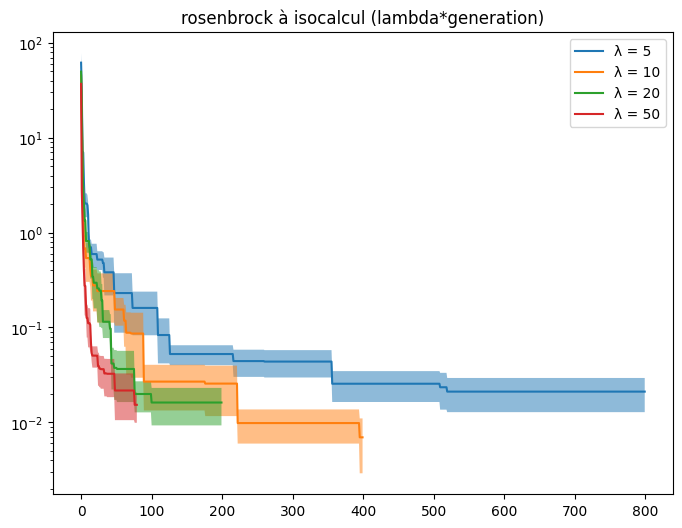

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.yscale('log')
genlam = 20*200
sig = 1

for lam in [5, 10, 20, 50] :
    f = himmelblau_v
    runs = []
    for i in range(5):
        x = np.random.rand(2)*10-5
        fits, _ = oneplus_lambda(x, f,lam=lam, gens=genlam//lam)
        runs += [fits]
    runs = np.array(runs)
    runs_mean = np.mean(runs, 0)
    runs_std = np.std(runs, 0)

    plt.fill_between(range(len(runs[0])), runs_mean+0.5*runs_std, runs_mean-0.5*runs_std, alpha=0.5)
    plt.plot(range(len(runs[0])), runs_mean, label=f"λ = {lam}")
plt.legend()
plt.title(f"rosenbrock à isocalcul (lambda*generation={genlam}) et σ={sig}")
plt.show()


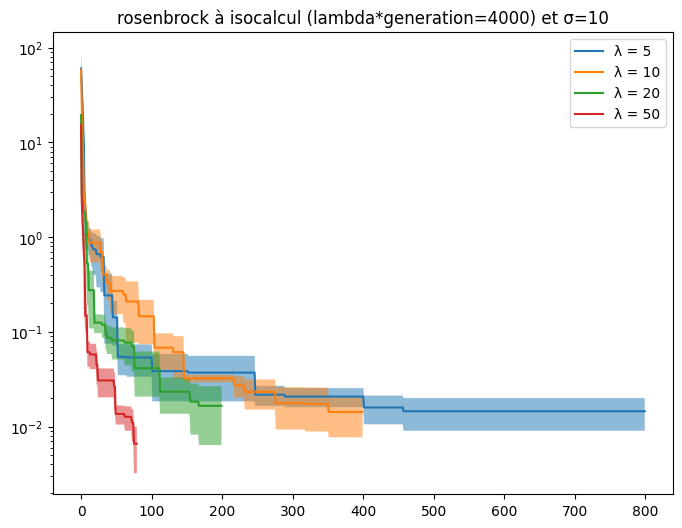

In [53]:
fig = plt.figure(figsize=(8, 6))
plt.yscale('log')
genlam = 20*200
sig = 10

for lam in [5, 10, 20, 50] :
    f = himmelblau_v
    runs = []
    for i in range(5):
        x = np.random.rand(2)*10-5
        fits, _ = oneplus_lambda(x, f,lam=lam, gens=genlam//lam)
        runs += [fits]
    runs = np.array(runs)
    runs_mean = np.mean(runs, 0)
    runs_std = np.std(runs, 0)

    plt.fill_between(range(len(runs[0])), runs_mean+0.5*runs_std, runs_mean-0.5*runs_std, alpha=0.5)
    plt.plot(range(len(runs[0])), runs_mean, label=f"λ = {lam}")
plt.legend()
plt.title(f"rosenbrock à isocalcul (lambda*generation={genlam}) et σ={sig}")
plt.show()

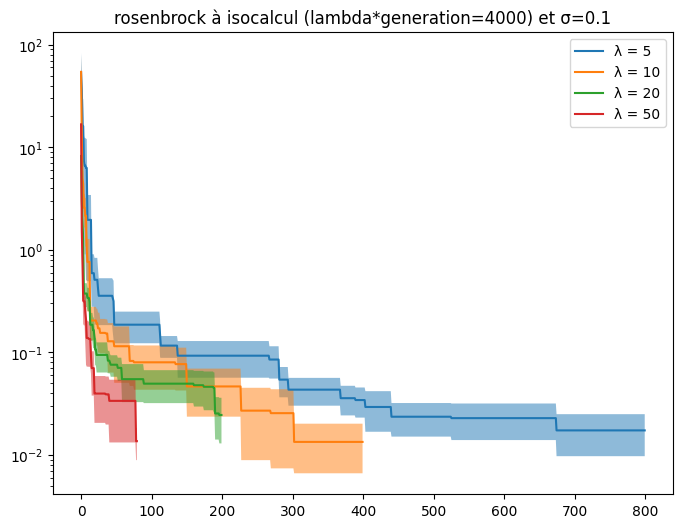

In [54]:
fig = plt.figure(figsize=(8, 6))
plt.yscale('log')
genlam = 20*200
sig = 0.1

for lam in [5, 10, 20, 50] :
    f = himmelblau_v
    runs = []
    for i in range(5):
        x = np.random.rand(2)*10-5
        fits, _ = oneplus_lambda(x, f,lam=lam, gens=genlam//lam)
        runs += [fits]
    runs = np.array(runs)
    runs_mean = np.mean(runs, 0)
    runs_std = np.std(runs, 0)

    plt.fill_between(range(len(runs[0])), runs_mean+0.5*runs_std, runs_mean-0.5*runs_std, alpha=0.5)
    plt.plot(range(len(runs[0])), runs_mean, label=f"λ = {lam}")
plt.legend()
plt.title(f"rosenbrock à isocalcul (lambda*generation={genlam}) et σ={sig}")
plt.show()

<div class="alert alert-success">
    <h3>Exercise</h3>
    Visualize the two other functions, Rosenbrock and the warped Rastrigin function. Try the $(1+\lambda)$ algorithm on these other functions.
</div>

# <a name="gradient">2.</a> Approximating the gradient

In the $(1+\lambda)$ ES, we move from the best point in a population to the best point in the next randomly sampled population. However, with the population information, we can do better than that; we can move in the direction of the gradient approximated by the fitness values of the population. This can also better use the full population information, combining all fitness information instead of selecting the best fitness value.

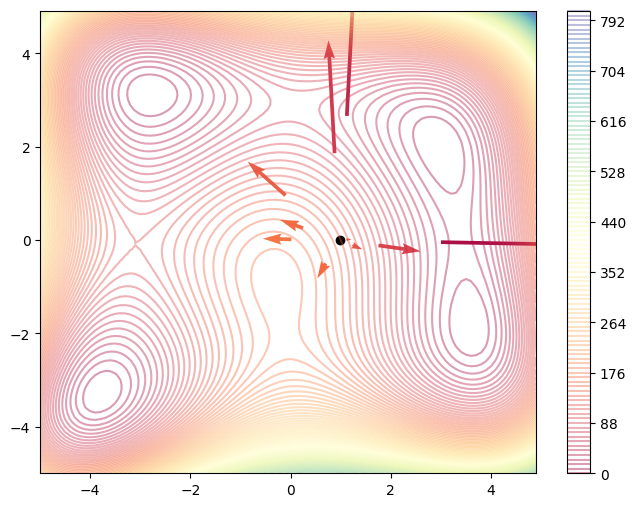

In [11]:
x = np.random.rand(2) * 4 - 2
x_t = np.array([x + np.random.normal(size=(2,)) for i in range(10)])
fits = himmelblau(x_t[:, 0], x_t[:, 1])

fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.quiver(x_t[:, 0], x_t[:, 1], x_t[:, 0]-x[0], x_t[:, 1]-x[1],
           fits, scale=fits/100, scale_units='xy', cmap='Spectral', norm=norm)
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

First we normalize all fitness values by the average $\mu(f(x))$ and standard deviation $\sigma(f(x))$ of the population. This is to make the movement based on the relative fitness in the population as opposed to the absolute fitness in the search space.

$A = \frac{f(x) - \mu(f(x))}{\sigma(f(x))}$

We'll then define a vector at each point, $x_i - x$. Note that since $x_i = x + N(0, 1)$, we could store just this original random sampled point from $N(0, 1)$ as our vector.

$N_i = x_i - x$

We multiply $A$ by all individual vectors which scales the vector magnitude by the relative fitness. Finally, we sum all vectors and divide by $\lambda$ to get the weighted average.

$\frac{1}{\lambda}\sum_i A_i N_i$

This is equivalent to the dot product of the fitness vector $A$ and the positional vector $N$. We consider this an approximation of the gradient of $f$, as it tells us the change in $f$ over movement in $x$. We can descend along this gradient approximation to minimize:

$\nabla f \approx -\frac{A \cdot N}{\lambda}$

In [12]:
A = (fits - np.mean(fits)) / np.std(fits)
N = x_t - x
G = -np.dot(A, N) / 10

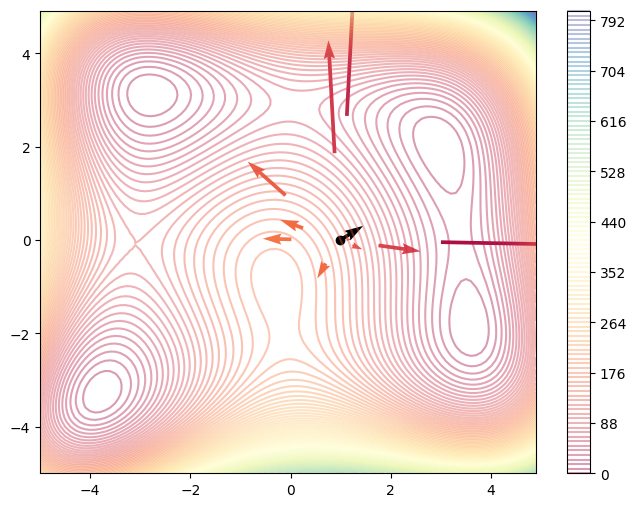

In [13]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.quiver(x_t[:, 0], x_t[:, 1], x_t[:, 0]-x[0], x_t[:, 1]-x[1],
           fits, scale=fits/100, scale_units='xy', cmap='Spectral', norm=norm)
plt.quiver(x[0], x[1], G[0], G[1])
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

We have our approximate gradient direction, but how far should we move in it? We'll define a learning rate variable $\alpha$ as the fixed magnitude of movement for now, so our update of $x$ is then

$x = x - \alpha\frac{A \cdot N}{\lambda}$

Let's put this all together as an Evolutionary Strategy. It is a $(\mu, \lambda)$ ES as multiple individuals $\mu$ inform the next generation; however, these individuals are not kept for the next generation.

    Initialize x randomly in ℝ
    while not terminate
        for i in [1,λ]
            N_i = 𝑁(0, 1)
            F_i = f(x + N_i)
        A = (F−𝜇(F))/𝜎(F)
        x = x - 𝛼(A⋅N)/𝜆

In [14]:
def mu_lambda(x, fitness, gens=200, lam=10, alpha=0.2, verbose=False):
    x_best = x
    f_best = fitness(x)
    fits = np.zeros(gens)
    for g in range(gens):
        N = np.random.normal(size=(lam, len(x)))
        F = np.zeros(lam)
        for i in range(lam):
            ind = x + N[i, :]
            F[i] = fitness(ind)
            if F[i] < f_best:
                f_best = F[i]
                x_best = ind
                if verbose:
                    print(g, " ", f_best)
        fits[g] = f_best
        mu_f = np.mean(F)
        std_f = np.std(F)
        A = F
        if std_f != 0:
            A = (F - mu_f) / std_f
        x = x - alpha * np.dot(A, N) / lam
    return fits, x_best

In [15]:
f = himmelblau_v
runs = []
for i in range(5):
    x = np.random.randn(2)
    fits, _ = mu_lambda(x, f)
    runs += [fits]
runs = np.array(runs)
runs_mean = np.mean(runs, 0)
runs_std = np.std(runs, 0)

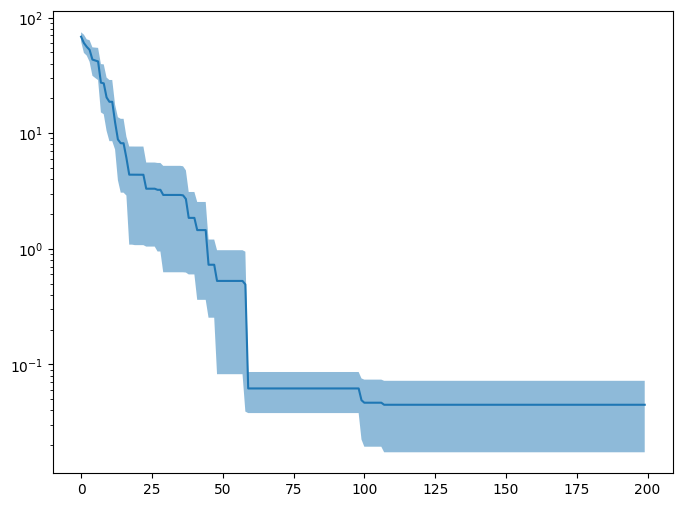

In [16]:
fig = plt.figure(figsize=(8, 6))
plt.fill_between(range(len(runs[0])), runs_mean+0.5*runs_std, runs_mean-0.5*runs_std, alpha=0.5)
plt.plot(range(len(runs[0])), runs_mean)
plt.yscale('log')

<div class="alert alert-success">
    <h3>Exercise</h3>
    
Study the impact of the $\alpha$ parameter by modifying it and re-running the optimization. Compare the best parameters found with the results from the $(1+\lambda)$ ES.
</div>

# <a name="canonical">3.</a> Canonical ES

We can make two observations about our current $(\mu, \lambda)$ Evolutionary Strategy:

1. Not all $\lambda$ points may be useful for the centroid update
2. Exact gradient information may be less useful than relative *rank* of individual fitness

Let's illustrate this point in the Himmelblau function. Instead of using all $\lambda$ points, we'll use a smaller value of $\mu$, for example $\frac{1}{2}\lambda$. We'll also create a list of weights which exponentially decreases from the first to last weight.

In [17]:
mu = 5
w = np.log(mu + 1/2) - np.log(np.arange(1, mu+1))
w /= np.sum(w)
w

array([0.45627265, 0.2707531 , 0.16223112, 0.08523355, 0.02550959])

As before, we create a random starting point and then add Gaussian noise to create offspring.

In [18]:
np.random.seed(123)
x = np.random.rand(2) * 4 - 2
N = np.random.normal(size=(10,2))
x_t = x + N
fits = himmelblau(x_t[:, 0], x_t[:, 1])
fits

array([149.43579676, 141.1815117 , 140.88616568,  76.38774424,
       178.41541966,  59.61119289, 173.12493856,   5.5135972 ,
        93.21569448,  90.44989743])

Now, however, instead of directly using fitness values, we'll select the best individuals and update using their weighted values.

In [19]:
sorted_ids = np.argsort(fits)
weighted = N[sorted_ids[:mu]] * w.reshape(mu, 1)
weighted

array([[ 1.00650556,  0.99777068],
       [ 0.40379836, -0.17298469],
       [ 0.20537425, -0.14061226],
       [ 0.06284854,  0.12706038],
       [ 0.02561301,  0.00985146]])

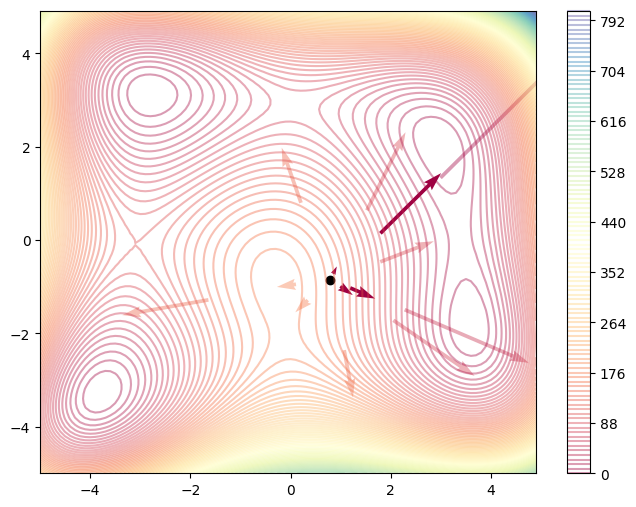

In [20]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.quiver(x_t[:, 0], x_t[:, 1], x_t[:, 0]-x[0], x_t[:, 1]-x[1],
           fits, scale=fits/100, scale_units='xy', cmap='Spectral', norm=norm, alpha=0.4)
plt.quiver(x[0]+weighted[:, 0], x[1]+weighted[:, 1], weighted[:, 0], weighted[:, 1],
           w, scale_units='xy', cmap='Spectral', norm=norm)
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

<div class="alert alert-success">
    <h3>Exercise</h3>
    
Consider the Rosenbrock function. How do you expect the gradient rankings to compare to the gradient information? Will they be very similar or different? Plot a sample to investigate.
</div>

The first point is clear: using all points in the centroid update could pull it away from nearby optima. The second point is a bit harder to understand, but motivation is this: any transformation to the search space which **preserves rank** for the top $\mu$ individuals does not change the update. This invariance property is helpful to search because it increases the predictive power of the fitness by inducing problem equivalence classes.

Hansen, N., Ros, R., Mauny, N., Schoenauer, M., & Auger, A. (2011). Impacts of invariance in search: When CMA-ES and PSO face ill-conditioned and non-separable problems. Applied Soft Computing, 11(8), 5755-5769.

Incorporating these two changes to the previous $(\mu, \lambda)$ ES brings us an ES referred to as Canonical ES

<img src="imgs/canonical.png" width="40%" height="auto">

Chrabaszcz, P., Loshchilov, I., & Hutter, F. (2018, July). Back to basics: benchmarking canonical evolution strategies for playing Atari. In Proceedings of the 27th International Joint Conference on Artificial Intelligence (pp. 1419-1426). [code](https://github.com/PatrykChrabaszcz/Canonical_ES_Atari)

While this evolutionary strategy is simple, it has been used to evolve deep neural networks capable of playing Atari games. It is competitive with an ES developed by OpenAI, and they are both competitive with deep reinforcement learning.

<img src="imgs/canonical_results.png" width="80%" height="auto">

<div class="alert alert-warning">

<h3>Embarrassingly parallel ES</h3>

All ES examples we've seen so far use sequential evaluation of individuals in a single thread. However, evaluations can be done entirely in parallel. Evaluation is by far the most computationally expensive part of the algorith and the fact that it is embarrassingly parallel means that the wall clock time of evolutionary algorithms in general can be greatly reduced by parallelizing over multiple threads.
    
</div>

We can use this weighted sum gradient estimate to make a new ES function for Canonical.

In [21]:
def canonical(x, fitness, gens=200, mu=10, lam=20, verbose=False):
    # best values and fitness vector for logging
    x_best = x
    f_best = fitness(x)
    fits = np.zeros(gens)
    
    # calculate weight list
    w = np.log(mu + 1/2) - np.log(np.arange(1, mu+1))
    w /= np.sum(w)
    
    # generation loop
    for g in range(gens):
        # calculate new individuals
        N = np.random.normal(size=(lam,2))
        x_t = x + N
        # evaluate individuals
        F = [fitness(x_t[i, :]) for i in range(lam)]
        # store best individual for logging
        for i in range(lam):
            if F[i] < f_best:
                f_best = F[i]
                x_best = x_t[i]
                if verbose:
                    print(g, " ", f_best)
        fits[g] = f_best
        # use weighted sum to update center
        sorted_ids = np.argsort(F)
        weighted = N[sorted_ids[:mu]] * w.reshape(mu, 1)
        s = np.mean(weighted, axis=0)
        x = x + s
        
    return fits, x_best

<div class="alert alert-success">
    <h3>Exercise</h3>
    
Compare the $(1+\lambda)$, $(\mu,\lambda)$, and Canonical ES on the Rosenbrock and warped Rastrigin functions. Is there a clearly superior ES out of these three?
</div>

In [22]:
def compare_es(es_list, f, n_runs=5):
    means = []
    devs = []
    max_g = 0
    for e in range(len(es_list)):
        runs = []
        for i in range(5):
            x = np.random.rand(2)*10-5
            fits, _ = es_list[e](x, f)
            runs += [fits]
            max_g = np.maximum(max_g, len(fits))
        runs = np.array(runs)
        runs_mean = np.mean(runs, 0)
        runs_std = np.std(runs, 0)
        means.append(runs_mean)
        devs.append(runs_std)

    means = np.array(means)
    devs = np.array(devs)
    fig = plt.figure(figsize=(8, 6))
    for e in range(len(es_list)):
        plt.fill_between(range(max_g), means[e]+0.5*devs[e], means[e]-0.5*devs[e], alpha=0.5)
        plt.plot(range(max_g), means[e], label=str(e))
    plt.legend()
    plt.yscale('log')

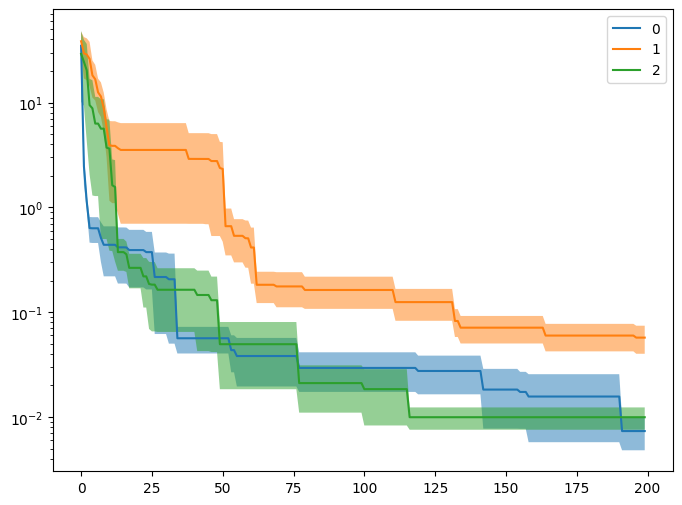

In [23]:
compare_es([oneplus_lambda, mu_lambda, canonical], himmelblau_v)

# <a name="cmaes">4.</a> CMAES part 1: Maximum Likelihood Estimation

Covariance Matrix Adaptation Evolutionary Strategy, or CMA-ES [1, 2], is one of the most well-known evolutionary algorithms in general and is a state-of-the-art algorithm for continuous optimization. The strength of this method is that it adapts the distribution it uses to generate the next population based on the current distribution of individuals. Until now, we were limited to a Normal distribution with a static $\sigma$. The adaptive distribution of CMA-ES means it will cross search spaces faster and narrow in more exactly on optimal points.

[1] Hansen, Nikolaus, and Andreas Ostermeier. "Adapting arbitrary normal mutation distributions in evolution strategies: The covariance matrix adaptation." Proceedings of IEEE international conference on evolutionary computation. IEEE, 1996.

[2] Hansen, Nikolaus, and Andreas Ostermeier. "Completely derandomized self-adaptation in evolution strategies." Evolutionary computation 9.2 (2001): 159-195.

Specifically, the things that CMA-ES improves over the previous Evolutionary Strategies we've seen is that it:
+ combines information from multiple individuals (as in $(\mu, \lambda)$ and Canonical ES)
+ combines information from multiple generations
+ transforms the distribution of the new population to match the search space
+ adapts the step size to prevent premature convergence

One improvement in CMA-ES which we've already seen is the use of **fitness rank** instead of direct fitness for the update. However, instead of directly updating a centroid, CMA-ES updates a covariance matrix.

CMA-ES uses two principles to achieve this: maximum likelihood estimation and step-size control. We'll start with maximum likelihood estimation, which consists of increasing the probability of successful points. CMA-ES will update the population center by taking the weighted average of high-fitness individuals.

In [24]:
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = himmelblau(X, Y)

In [25]:
lam = 20
x = np.random.rand(2) * 4 - 2
N = np.random.normal(size=(lam,2))
x_t = x + N
fits = himmelblau(x_t[:, 0], x_t[:, 1])

First, we select the top $\mu$ individuals based on their fitness values. We'll then weight their importance by their fitness rank, using a static weight vector $w$. This weight vector $w$ is a hyperparameter in CMA-ES, but there is a standard normalized logarithmic weight scale used by most. Note that the weight is not their fitness values but rather just the rank. This has been demonstrated to aid in search in ill-formed search spaces.

In [26]:
mu = 10
sorted_ids = np.argsort(fits)
w = np.log(mu + 1/2) - np.log(np.arange(1, mu+1))
w /= np.sum(w)
weighted = N[sorted_ids[:mu]] * w.reshape(mu, 1)
s = np.mean(weighted, axis=0)
s

array([-0.11822749, -0.01618228])

This $s$ direction vector is similar to the gradient estimation from the last exercise. However, in CMA-ES, only the top $\mu$ individuals are used to calculate $s$, and instead of directly using fitness values, $s$ is calculated using weight based on fitness rank. We can compare the two vectors.

In [27]:
A = (fits - np.mean(fits)) / np.std(fits)
G = -np.dot(A, N) / lam

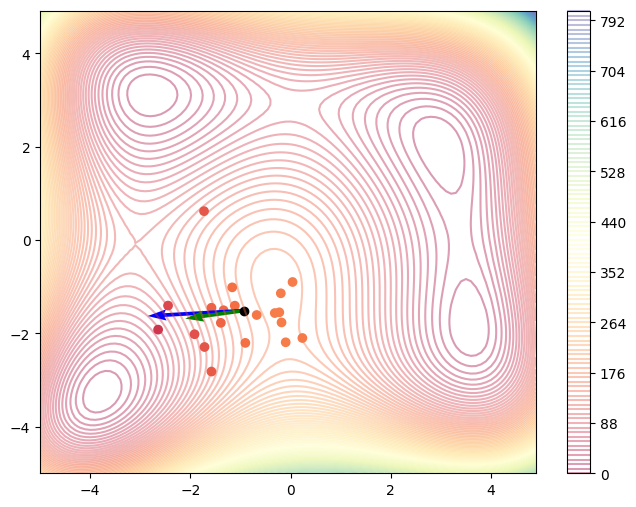

In [28]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.scatter(x_t[:, 0], x_t[:, 1], c=fits, cmap='Spectral', norm=norm)
plt.quiver(x[0], x[1], G[0], G[1], color='b', scale=4)
plt.quiver(x[0], x[1], s[0], s[1], color='g', scale=1)
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

While we're only using the fitness information for a ranked weighting, this direction vector $s$ can be seen as a gradient approximation. As before, we can use this gradient information to update the center of our distribution. This is the first step of maximum likelihood estimation, aligning the distribution center with the weighted average of the best solutions.

In [29]:
x = x + s

A fundamental idea behind CMA-ES is to estimate the covariance between the selected samples, and to use this covariance matrix to shape the next distribution. A covariance matrix measures the joint variability between the different dimensions of the objective function. Covariance matrices are outside of the scope of this class, but this article has more details:
https://datascienceplus.com/understanding-the-covariance-matrix/

We start CMA-ES with the identity matrix as the initial covariance matrix, assuming each variable is independent and has a standard deviation of 1.

In [30]:
C = np.eye(2)
C

array([[1., 0.],
       [0., 1.]])

At each step, we update $C = C + ss^T$. This will use the weighted sample average as an estimate of the covariance. In CMA-ES, it is referred to as the rank one covariance update. For problems of higher dimension, there is an additional matrix update.

In [31]:
C = C + np.outer(s, (s).T)
C

array([[1.01397774, 0.00191319],
       [0.00191319, 1.00026187]])

The eigen decomposition of the covariance matrix is then used to transform the Normal distribution to match the search space. This is the second part of maximum likelihood estimation: by pulling samples from a distribution fit to performant parts of the search space, there is a higher chance of sampling good individuals. The mean of the distribution $x$ and the shape given by $C$ together maximize this likelihood.

In [32]:
N = np.random.normal(size=(lam, 2))
x_N = x + N
eigenvalues, eigenvectors = np.linalg.eig(C)
x_C = x + np.array([np.dot(eigenvectors, np.sqrt(eigenvalues) * N[i, :]) for i in range(lam)])

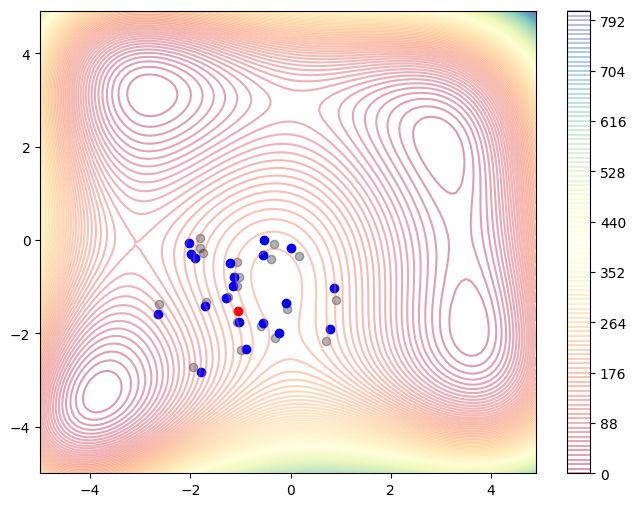

In [33]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.scatter(x_N[:, 0], x_N[:, 1], c='k', alpha=0.3)
plt.scatter(x_C[:, 0], x_C[:, 1], c='b')
plt.scatter(x[0], x[1], c='r')
fig.colorbar(cs)
plt.show()

We can consider this improvement alone and add it to the Canonical ES defined above. The only modification is that, instead of sampling from the Normal distribution, we'll transform the normal distribution using the covariance matrix first.

In [34]:
def covariance_es(x, fitness, gens=200, mu=10, lam=20, verbose=False):
    # best values and fitness vector for logging
    x_best = x
    f_best = fitness(x)
    fits = np.zeros(gens)
    
    # calculate weight list and first covariance matrix
    w = np.log(mu + 1/2) - np.log(np.arange(1, mu+1))
    w /= np.sum(w)
    C = np.eye(2)
    
    # generation loop
    for g in range(gens):
        # calculate new individuals
        N = np.random.normal(size=(lam,2))
        x_N = x + N
        eigenvalues, eigenvectors = np.linalg.eig(C)
        x_C = x + np.array([np.dot(eigenvectors, np.sqrt(eigenvalues) * N[i, :]) for i in range(lam)])
        # evaluate individuals
        F = [fitness(x_C[i, :]) for i in range(lam)]
        # store best individual for logging
        for i in range(lam):
            if F[i] < f_best:
                f_best = F[i]
                x_best = x_C[i]
                if verbose:
                    print(g, " ", f_best)
        fits[g] = f_best
        # use weighted sum to update center
        sorted_ids = np.argsort(F)
        weighted = N[sorted_ids[:mu]] * w.reshape(mu, 1)
        s = np.mean(weighted, axis=0)
        x = x + s
        C = C + np.outer(s, (s).T)
        
    return fits, x_best

<div class="alert alert-success">
    <h3>Exercise</h3>
    
Compare this new ES to Canonical ES. Does the inclusion of the Covariance matrix improve the results?
</div>

# <a name="cmaes">5.</a> CMAES part 2: Step size adaptation

To understand the second main feature of CMA-ES, step size adaptation, let's go back to the first ES defined, the $(1+\lambda)$. We can include an important hyperparameter in this method: the Normal distribution size or standard deviation.

In [35]:
def oneplus_lambda(x, f, std=1, gens=200, lam=20):
    x_best = x
    f_best = f(x)
    fits = np.zeros(gens)
    for g in range(gens):
        N = np.random.normal(size=(lam, len(x))) * std
        for i in range(lam):
            ind = x + N[i, :]
            fi = f(ind)
            if fi < f_best:
                f_best = fi
                x_best = ind
        x = x_best
        fits[g] = f_best
    return fits, x_best

By comparing different values of standard deviation, we can see that this has a major effect on the final result.

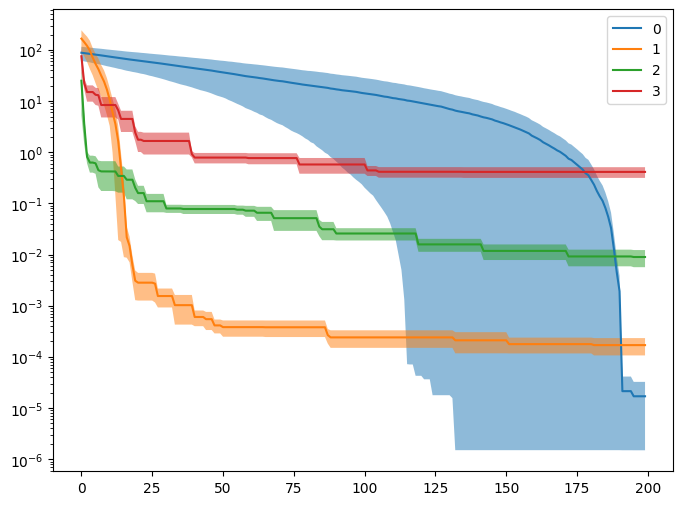

In [36]:
f0 = lambda x, f: oneplus_lambda(x, f, std=0.01)
f1 = lambda x, f: oneplus_lambda(x, f, std=0.1)
f2 = lambda x, f: oneplus_lambda(x, f, std=1)
f3 = lambda x, f: oneplus_lambda(x, f, std=10)

compare_es([f0, f1, f2, f3], himmelblau_v)

The second main feature in CMA-ES besides maximum likelihood estimation is step-size control. This is very similar to the temperature parameter in simulated annealing: it updates over time to allow for either more exploration or more precision.

<div class="alert alert-success">
    <h3>Exercise</h3>
    
Make the step size change during the $(1+\lambda)$ ES for the Himmelblau function. You can try decreasing `std` by a small amount each step, or using exponential decay, or a rule like the one in simulated annealing. Then, once it works, apply this strategy to Rosenbrock. Does that beat the standard $(1+\lambda)$?
</div>

The step size control used in CMA-ES uses the gradient estimate to determine if the step size should be expanded (exploration) or decreased (exploitation). [This article](http://www.cmap.polytechnique.fr/~nikolaus.hansen/es-overview-2015.pdf) gives an overview of different ES, including the step size control used in CMA-ES. The following algorithm is a standard $(\mu, \lambda)$ algorithm with the step size control added.

<img src="imgs/step_size.png">

We have the two parts of CMA-ES now: maximum likelihood estimation and step-size control. These two combine to modify the distribution, both in shape and size, over the search. As we see in the animation below, CMA-ES adapts the distribution to the search space.

<img src="https://user-images.githubusercontent.com/5564044/73486622-db5cff00-43e8-11ea-98fb-8246dbacab6d.gif">

<img src="imgs/cmaes.png">

To see CMA-ES in practice, we'll use the pycma package (https://github.com/CMA-ES/pycma). If you haven't installed it, do so here:

In [37]:
#!pip install cma

`pycma` is actively maintained by the CMA-ES author and has many more algorithm tricks and features than we've discussed here. [4] provides a good review of different CMA-ES modifications.

[4] Hansen, Nikolaus. "The CMA evolution strategy: a comparing review." Towards a new evolutionary computation. Springer, Berlin, Heidelberg, 2006. 75-102.

In [38]:
import cma
es = cma.CMAEvolutionStrategy(2 * [0], 0.1, {'popsize': 20, 'verb_disp': 1})

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 2 (seed=1042114, Wed Oct  8 11:26:22 2025)


In [39]:
solutions = np.array(es.ask())
es.tell(solutions, [himmelblau(x[0], x[1]) for x in solutions])
es.disp_annotation()
es.disp();

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 1.654127028666178e+02 1.0e+00 1.47e-01  1e-01  2e-01 0:00.0


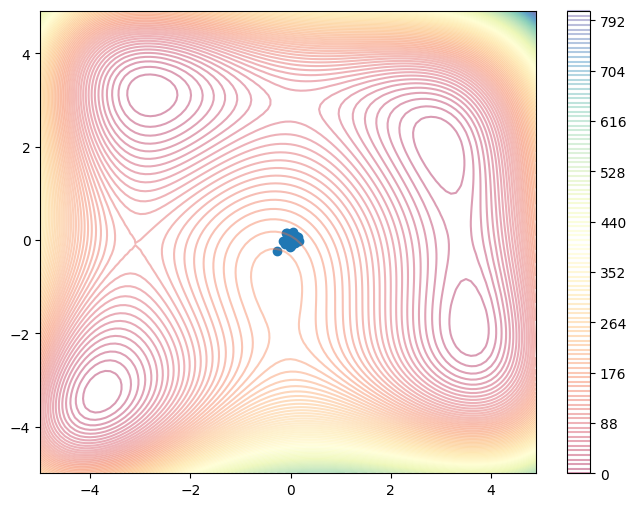

In [40]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot()
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.scatter(solutions[:, 0], solutions[:, 1])
fig.colorbar(cs)
plt.show()

In [41]:
def generation(i, es, ax):
    solutions = np.array(es.ask())
    es.tell(solutions, [himmelblau(x[0], x[1]) for x in solutions])
    
    ax.clear()
    ax.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
    ax.scatter(solutions[:, 0], solutions[:, 1])
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.plot()

In [42]:
es = cma.CMAEvolutionStrategy(2 * [0], 0.1, {'popsize': 20})

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 2 (seed=1106947, Wed Oct  8 11:26:22 2025)


In [43]:
import matplotlib.animation as animation
from IPython import display
fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
fig.tight_layout()
frames = 20
animator = animation.FuncAnimation(fig, generation, fargs=(es, ax), frames=frames, interval=250, blit=False)
display.display(display.HTML(animator.to_html5_video()))
plt.close();

ES, and particularly CMA-ES, have been widely used in many applications. Any problem which can be modelled as a continuous optimizaton problem can use an evolutionary strategy, and CMA-ES is the state of the art for ES. Here is a short list of applications:
    
+ Gagné, C., Beaulieu, J., Parizeau, M., & Thibault, S. (2008). Human-competitive lens system design with evolution strategies. Applied Soft Computing, 8(4), 1439-1452.
+ Bayer, P., & Finkel, M. (2007). Optimization of concentration control by evolution strategies: Formulation, application, and assessment of remedial solutions. Water resources research, 43(2).
+ Kämpf, J. H., & Robinson, D. (2009). A hybrid CMA-ES and HDE optimisation algorithm with application to solar energy potential. Applied Soft Computing, 9(2), 738-745.
+ Maki, A., Sakamoto, N., Akimoto, Y., Nishikawa, H., & Umeda, N. (2020). Application of optimal control theory based on the evolution strategy (CMA-ES) to automatic berthing. Journal of Marine Science and Technology, 25(1), 221-233.
+ Loshchilov, I., & Hutter, F. (2016). CMA-ES for hyperparameter optimization of deep neural networks. arXiv preprint arXiv:1604.07269.
+ Fukagata, K., Kern, S., Chatelain, P., Koumoutsakos, P., & Kasagi, N. (2008). Evolutionary optimization of an anisotropic compliant surface for turbulent friction drag reduction. Journal of Turbulence, (9), N35.

<div class="alert alert-success">
    <h3>Exercise</h3>
    
Compare CMA-ES to the $(1+\lambda)$, $(\mu, \lambda)$, and Canonical ES. Plot the mean and standard deviation over 5 independent runs, as before.
</div>